In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

from utilities2015 import *

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

# import cv2

from networkx import from_dict_of_lists, Graph, adjacency_matrix, dfs_postorder_nodes
from networkx.algorithms import node_connected_component

stack_name = 'MD593'

In [3]:
section_id = 117
dm = DataManager(stack=stack_name, section=section_id, segm_params_id='gridsize100')
# dm._load_image()

In [4]:
texton_hists = dm.load_pipeline_result('texHist')
segmentation = dm.load_pipeline_result('segmentation')
n_superpixels = segmentation.max() + 1
textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1
neighbors = dm.load_pipeline_result('neighbors')

In [5]:
edge_coords = dict(dm.load_pipeline_result('edgeCoords'))

In [6]:
neighbor_graph = from_dict_of_lists(dict(enumerate(neighbors)))

neighbors_long = dict([(s, set([n for n in nbrs if len(edge_coords[frozenset([s,n])]) > 10])) 
                       for s, nbrs in enumerate(neighbors)])

neighbor_long_graph = from_dict_of_lists(neighbors_long)

In [7]:
sp_centroids = dm.load_pipeline_result('spCentroids')[:, ::-1]

In [8]:
neighbor_hist_dists = [zip(list(neighbors[s]), chi2s(texton_hists[s], texton_hists[list(neighbors[s])])) for s in range(n_superpixels)]

In [ ]:
edge_dists = {}
for e in edge_coords.iterkeys():
    i, j = e
    edge_dists[e] = chi2(texton_hists[i], texton_hists[j])

In [ ]:
plt.hist(edge_dists.values(), bins=100);

In [ ]:
segmentation_viz = dm.load_pipeline_result('segmentationWithText')

In [ ]:
import cv2
viz = img_as_ubyte(segmentation_viz[dm.ymin:dm.ymax+1, dm.xmin:dm.xmax+1])
for e, coords in edge_coords.iteritems():
    i, j = e
    if len(coords) > 50 and i != -1 and j != -1:
        cv2.line(viz, 
                 (sp_centroids[i,0].astype(np.int)-dm.xmin, sp_centroids[i,1].astype(np.int)-dm.ymin), 
                 (sp_centroids[j,0].astype(np.int)-dm.xmin, sp_centroids[j,1].astype(np.int)-dm.ymin), 
                 (255,0,0), int(30*edge_dists[e]))

In [ ]:
display(viz)

In [8]:
def compute_nearest_surround(cluster):
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds_list = list(surrounds)
    ds = np.squeeze(chi2s([cluster_avg], texton_hists[surrounds_list]))     
    surround_dist = ds.min()
    return surrounds_list[ds.argmin()]
    

def compute_cluster_score(cluster, texton_hists, verbose=False):
    
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    if len(surrounds) == 0: # single sp on background
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    surrounds_list = list(surrounds)
    
#     ds = np.squeeze(chi2s([cluster_avg], texton_hists[surrounds_list])) 
    ds = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2))
#     ds = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], kl))
    
#     sur_hists = [texton_hists[list(neighbors[s])].mean(axis=0) for s in surrounds_list]
#     ds = np.squeeze(cdist([cluster_avg], sur_hists, chi2))
    
    surround_dist = ds.min()
    if verbose:
        print 'min', surrounds_list[ds.argmin()]

#     surds, _ = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph)
    
#     compactness = len(surds[0])**2/float(len(cluster))
#     compactness = .001 * np.maximum(compactness-40,0)**2
    
#     size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
#     score = surround_dist - compactness + size_prior
    score = surround_dist
    
    if len(cluster) > 1:
        ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
        var = np.sum(ds**2)/len(ds)
    else:
        var = 0
    
    interior_dist = np.nan
    compactness = np.nan
    interior_pval = np.nan
    surround_pval = np.nan
    size_prior = np.nan
    
    return score, surround_dist, var, compactness, surround_pval, interior_pval, size_prior

In [9]:
import networkx
from itertools import chain

In [10]:
from skimage.feature import peak_local_max
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def grow_cluster4(seed, verbose=False, all_history=False):
    try:
    
        visited = set([])
        curr_cluster = set([])

        candidate_scores = [0]
        candidate_sps = [seed]

        score_tuples = []
        added_sps = []
        n_sps = []
        
        cluster_list = []
        addorder_list = []
        
        iter_ind = 0

        hull_begin = False
        
        nearest_surrounds = []
        toadd_list = []

        while len(candidate_sps) > 0:
            
            if verbose:
                print '\niter', iter_ind

            best_ind = np.argmax(candidate_scores)

            just_added_score = candidate_scores[best_ind]
            sp = candidate_sps[best_ind]

            del candidate_scores[best_ind]
            del candidate_sps[best_ind]

            if sp in curr_cluster:
                continue

            curr_cluster.add(sp)
            added_sps.append(sp)

            extra_sps = []
            
#             sg = neighbor_graph.subgraph(list(set(range(n_superpixels))-curr_cluster))
            sg = neighbor_long_graph.subgraph(list(set(range(n_superpixels))-curr_cluster))
            for c in networkx.connected_components(sg):
                if len(c) < 10: # holes
                    extra_sps.append(c)
            extra_sps = list(chain(*extra_sps))
            curr_cluster |= set(extra_sps)
            added_sps += extra_sps
                
#             if not hull_begin:
#                 pts = sp_centroids[list(curr_cluster)]
#                 # if all points are colinear, ConvexHull will fail
#                 try:
#                     hull = ConvexHull(pts, incremental=True)
#                     hull_begin = True
#                 except:
#                     pass

#             if hull_begin:
                
#                 hull.add_points([sp_centroids[sp]])

#                 vertices = hull.points[hull.vertices]
#                 mpath = Path(vertices)
#                 xmin, ymin = vertices.min(axis=0)
#                 xmax, ymax = vertices.max(axis=0)

#                 in_bbox_sps = np.where((sp_centroids[:,0] >= xmin) & (sp_centroids[:,1] >= ymin) & \
#                                 (sp_centroids[:,0] <= xmax) & (sp_centroids[:,1] <= ymax))[0]

#                 extra_sps_to_consider = np.asarray(list(set(in_bbox_sps)))
#                 if verbose:
#                     print '\nextra_sps_to_consider', extra_sps_to_consider
#                 if len(extra_sps_to_consider) > 0:
#                     in_hull = mpath.contains_points(sp_centroids[extra_sps_to_consider])
#                     if np.any(in_hull):
#                         extra_sps = extra_sps_to_consider[in_hull]
#                         hull.add_points(sp_centroids[extra_sps])
#                         curr_cluster |= set(list(extra_sps))
#                         added_sps += extra_sps.tolist()


            tt = compute_cluster_score(curr_cluster, texton_hists=texton_hists, verbose=verbose)
    
            nearest_surround = compute_nearest_surround(curr_cluster)
            nearest_surrounds.append(nearest_surround)
            
            tot, exterior, interior, compactness, surround_pval, interior_pval, size_prior = tt
            
            if np.isnan(tot):
                return [seed], -np.inf
            score_tuples.append(np.r_[just_added_score, tt])
                    
            n_sps.append(len(curr_cluster))
    
            # just_added_score, curr_total_score, exterior_score, interior_score, compactness_score, surround_pval,
            # interior_pval, size_prior

            if verbose:
                print 'add', sp
                print 'extra', extra_sps
                print 'added_sps', added_sps
                print 'curr_cluster', curr_cluster
                print 'n_sps', n_sps
                print 'tt', tot
                if len(curr_cluster) != len(added_sps):
                    print len(curr_cluster), len(added_sps)
                    raise                

#             visited.add(sp)
            
            cluster_list.append(curr_cluster.copy())
            addorder_list.append(added_sps[:])
            
            if interior > 0.003:
                break
            
#             if hull_begin:
#             visited |= set(list(extra_sps))
            
#             if hull_begin and len(extra_sps) > 0:
            candidate_sps = (set(candidate_sps) | \
                             (set.union(*[neighbors_long[i] for i in list(extra_sps)+[sp]]) - {-1})) - curr_cluster
#             else:
            
#             candidate_sps = (set(candidate_sps) | (neighbors[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster                
#             candidate_sps = (set(candidate_sps) | (neighbors[sp] - {-1})) - curr_cluster                

#             if hull_begin and len(extra_sps) > 0:
#                 candidate_sps = (set(candidate_sps) | ((set.union(*[neighbors_long[i] for i in list(extra_sps)]) | neighbors_long[sp]) - set([-1])) | (visited - curr_cluster)) - curr_cluster
#             else:
#                 candidate_sps = (set(candidate_sps) | (neighbors_long[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster

            candidate_sps = list(candidate_sps)
            
            h_avg = texton_hists[list(curr_cluster)].mean(axis=0)
        
#             candidate_scores = -chi2s([h_avg], texton_hists[candidate_sps])

            candidate_scores = -.5*chi2s([h_avg], texton_hists[candidate_sps])-\
                            .5*chi2s([texton_hists[seed]], texton_hists[candidate_sps])
            
#             candidate_scores = -chi2s([h_avg], texton_hists[candidate_sps])
#                                 -.5*chi2s([texton_hists[seed]], texton_hists[candidate_sps])
#                                 .5*chi2s([texton_hists[[1516,1517]].mean(axis=0)], texton_hists[candidate_sps])+\
#                                 .5*chi2s([texton_hists[[1935,1934]].mean(axis=0)], texton_hists[candidate_sps])
        
#             cand_hists = np.array([texton_hists[list(neighbors[s] - curr_cluster)].mean(axis=0) for s in candidate_sps])
#             candidate_scores = -chi2s([h_avg], cand_hists)
    
#             candidate_scores = -np.squeeze(cdist([h_avg], texton_hists[candidate_sps], kl))
            candidate_scores = candidate_scores.tolist()
#             candidate_scores = [-chi2(h_avg, texton_hists[i]) for i in candidate_sps]

            if verbose:
#                 print 'candidate', candidate_sps
                print 'candidate\n'
    
                for i,j in sorted(zip(candidate_scores, candidate_sps), reverse=True):
                    print i, j
                print 'best', candidate_sps[np.argmax(candidate_scores)]
                
            toadd_list.append(candidate_sps[np.argmax(candidate_scores)])

            if len(curr_cluster) > int(n_superpixels * 0.05):
                break
                
            iter_ind += 1

        score_tuples = np.array(score_tuples)
        scores = score_tuples[:,1]
        
        peaks_sorted, peakedness_sorted = find_score_peaks(scores)
        
        if all_history:
            return addorder_list, score_tuples, peaks_sorted, peakedness_sorted, nearest_surrounds, toadd_list
        else:
            return [addorder_list[i] for i in peaks_sorted], score_tuples[peaks_sorted, 1]
            
    except:
        print seed
        raise

In [11]:
def find_score_peaks(scores, min_size = 4, min_distance=10, threshold_rel=.3, peakedness_lim=.001,
                    peakedness_radius=5):
    
    if len(scores) > min_size + 1:
    
        peaks = peak_local_max(scores[min_size:]-scores[min_size:].min(), min_distance=min_distance, 
                                      threshold_rel=threshold_rel, exclude_border=False)
        if len(peaks) > 0:
            peaks = min_size + peaks.T
            peaks = peaks[0]

            peakedness = np.array([scores[p]-np.mean(np.r_[scores[p-peakedness_radius:p], 
                                                           scores[p+1:p+1+peakedness_radius]]) for p in peaks])

            peaks = peaks[peakedness > peakedness_lim]
            peakedness = peakedness[peakedness > peakedness_lim]

            peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
        else:
            peaks = np.array([np.argmax(scores[min_size:]) + min_size])
            peakedness = np.atleast_1d([scores[p]-np.mean(np.r_[scores[max(0, p-peakedness_radius):p], 
                                                           scores[p+1:min(p+1+peakedness_radius, len(scores))]]) 
                                       for p in peaks])
            peaks = peaks[peakedness > peakedness_lim]
            peakedness = peakedness[peakedness > peakedness_lim]
            peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
    else:
        peaks = np.array([np.argmax(scores)])
        peakedness = np.atleast_1d([scores[p]-np.mean(np.r_[scores[max(0, p-peakedness_radius):p], 
                                                           scores[p+1:min(p+1+peakedness_radius, len(scores))]]) 
                                       for p in peaks])
        peaks_sorted = peaks[scores[peaks].argsort()[::-1]]
    
    peakedness_sorted = np.atleast_2d(peakedness[scores[peaks].argsort()[::-1]])
    
    return peaks_sorted, peakedness_sorted    


In [19]:
t = time.time()
clusters_allhistory, score_tuples, peaks_sorted, \
peakedness_sorted, nearest_surrounds, best_candidate_list = grow_cluster4(1004, all_history=True, verbose=True)
print time.time() - t


iter 0
min 1003
add 1004
extra []
added_sps [1004]
curr_cluster set([1004])
n_sps [1]
tt 0.0144244531163
candidate

-0.014424453092 1003
-0.0885885519818 1056
-0.206431811693 952
-0.209058988632 1005
best 1003

iter 1
min 1055
add 1003
extra []
added_sps [1004, 1003]
curr_cluster set([1003, 1004])
n_sps [1, 2]
tt 0.0357533655881
candidate

-0.037939663868 1055
-0.0623433619043 1002
-0.0965373985913 1056
-0.124219401937 951
-0.196498852257 1005
-0.20276171019 952
best 1055

iter 2
min 1002
add 1055
extra []
added_sps [1004, 1003, 1055]
curr_cluster set([1003, 1004, 1055])
n_sps [1, 2, 3]
tt 0.0490447150221
candidate

-0.055285743586 1002
-0.0954788185405 1056
-0.110718586269 1054
-0.132303968529 951
-0.18987460448 1005
-0.208607037201 952
-0.510748138166 1107
best 1002

iter 3
min 1001
add 1002
extra []
added_sps [1004, 1003, 1055, 1002]
curr_cluster set([1002, 1003, 1004, 1055])
n_sps [1, 2, 3, 4]
tt 0.025364445555
candidate

-0.0338658584119 1001
-0.103947482304 1056
-0.111492611826 

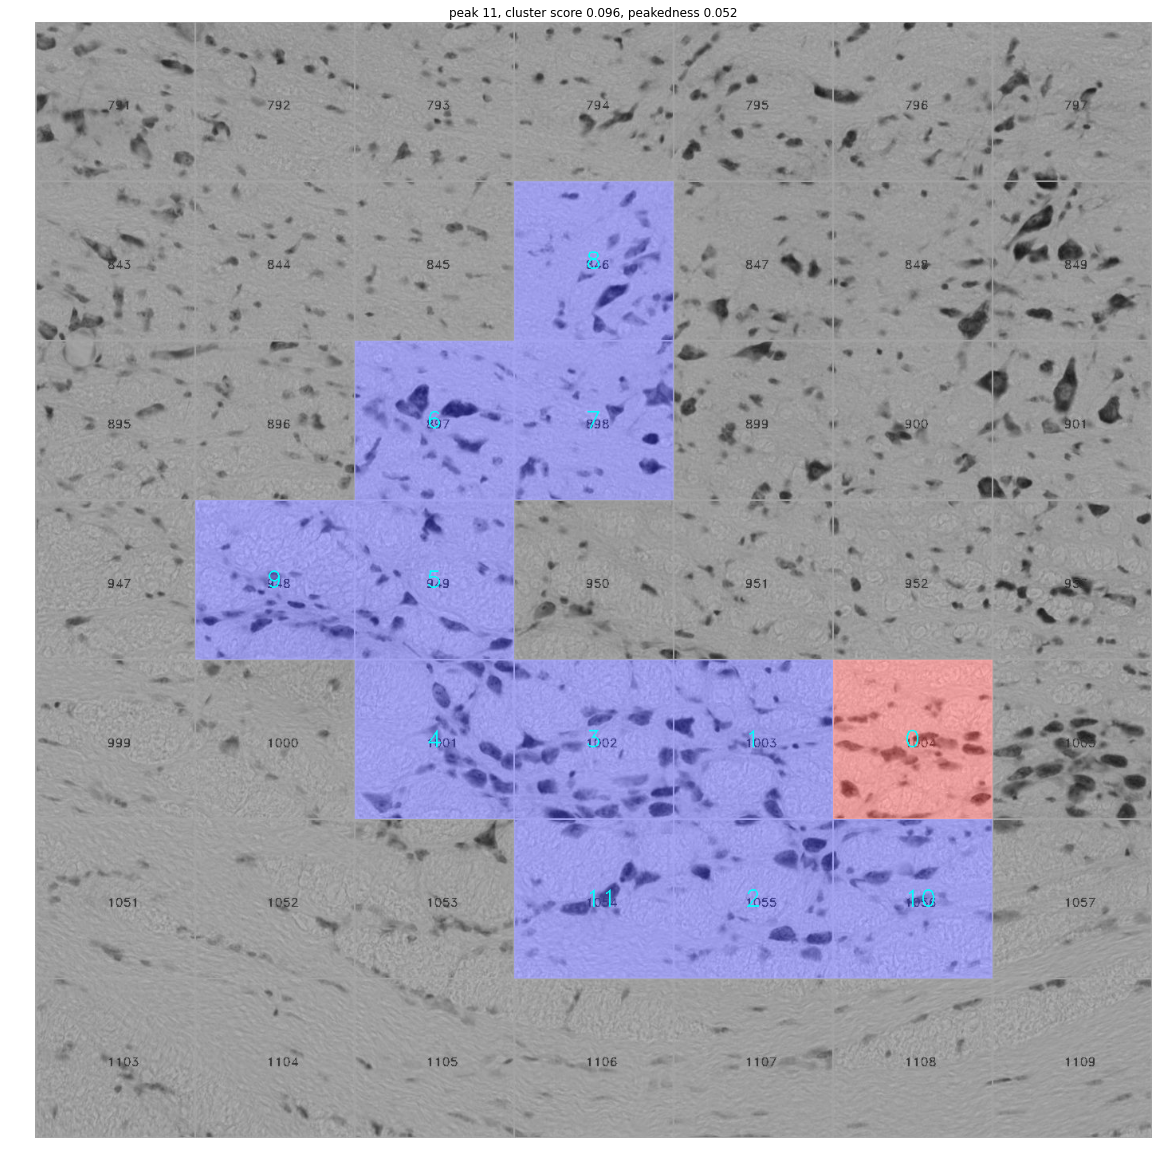

In [16]:
margin = 300

xmin = np.inf
ymin = np.inf
xmax = 0
ymax = 0

for i in peaks_sorted:
    centroids = sp_centroids[clusters_allhistory[i]]
    xmin = min(xmin, centroids[:,0].min(axis=0))
    xmax = max(xmax, centroids[:,0].max(axis=0))
    ymin = min(ymin, centroids[:,1].min(axis=0))
    ymax = max(ymax, centroids[:,1].max(axis=0))

xmin = int(max(0, xmin - margin))
ymin = int(max(0, ymin - margin))
xmax = int(min(dm.image_width, xmax + margin))
ymax = int(min(dm.image_height, ymax + margin))

for peak_ind, p in enumerate(peaks_sorted):
    viz = dm.visualize_cluster(clusters_allhistory[p], highlight_seed=True, seq_text=True,
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    plt.figure(figsize=(20,20))
    plt.imshow(viz)
    plt.axis('off')
    plt.title('peak %d, cluster score %.3f, peakedness %.3f'%(p, score_tuples[p, 1], peakedness_sorted[peak_ind]))
    plt.show()

In [ ]:
from subprocess import call

def show_growth_iteration(i, start_iter=0, end_iter=None, img_name=None):
    
    if end_iter is None:
        end_iter = len(clusters_allhistory) - 1

    viz = dm.visualize_multiple_clusters([[clusters_allhistory[i][0]], 
                                          clusters_allhistory[i][1:],
                                          [nearest_surrounds[i]],
                                          [best_candidate_list[i]]], alpha_blend=False,
                              ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    
    fig = plt.figure(figsize=(20,20))
    
    gs = gridspec.GridSpec(3, 3)
    
    ax_img = plt.subplot(gs[:2, :3])
    ax_hist = plt.subplot(gs[2, 2])
    ax_score = plt.subplot(gs[2, :2])
    
    ax_img.imshow(viz);
    ax_img.axis('off');
    
    ax_score.plot(score_tuples[:i+1,1])
    ax_score.set_xticks(range(start_iter, end_iter+1));
    ax_score.set_xlim([start_iter, end_iter+1])
    ax_score.set_ylim([score_tuples[:,1].min(), score_tuples[:,1].max()])
    
    c = clusters_allhistory[i]
    ax_hist.bar(range(n_texton), texton_hists[c].mean(axis=0));
    ax_hist.set_title('interior histogram');
    
    plt.title('iteration %d'%i);
    
    if img_name is not None:
        plt.savefig(img_name, bbox_inches='tight', pad_inches=0.1);
        plt.close(fig)
    else:
        plt.show();
        
def create_growth_video(start_iter=0, end_iter=None, interval=2, fps=1, output_dir='/tmp/growth_snapshots'):
    
    if end_iter is None:
        end_iter = len(clusters_allhistory) - 1

    call('rm -r %s'%output_dir, shell=True)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    Parallel(n_jobs=8)(delayed(show_growth_iteration)(i, start_iter, end_iter, img_name=output_dir+'/iter%02d.jpg'%i) 
                        for i, it in enumerate(range(start_iter, end_iter+1, interval)))

    cmd = """/home/yuncong/csd395/ffmpeg-git-20150927-64bit-static/ffmpeg -framerate %(fps)d -start_number 0 -i %(output_dir)s/iter%%02d.jpg -c:v libx264 -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -r 30 -pix_fmt yuv420p %(output_dir)s/growth.mp4"""%{'fps':1, 'output_dir': output_dir}
#     print cmd
    call(cmd, shell=True)

In [ ]:
show_growth_iteration(11)

In [ ]:
t = time.time()
create_growth_video(0, 50, 1)
print time.time() -t 

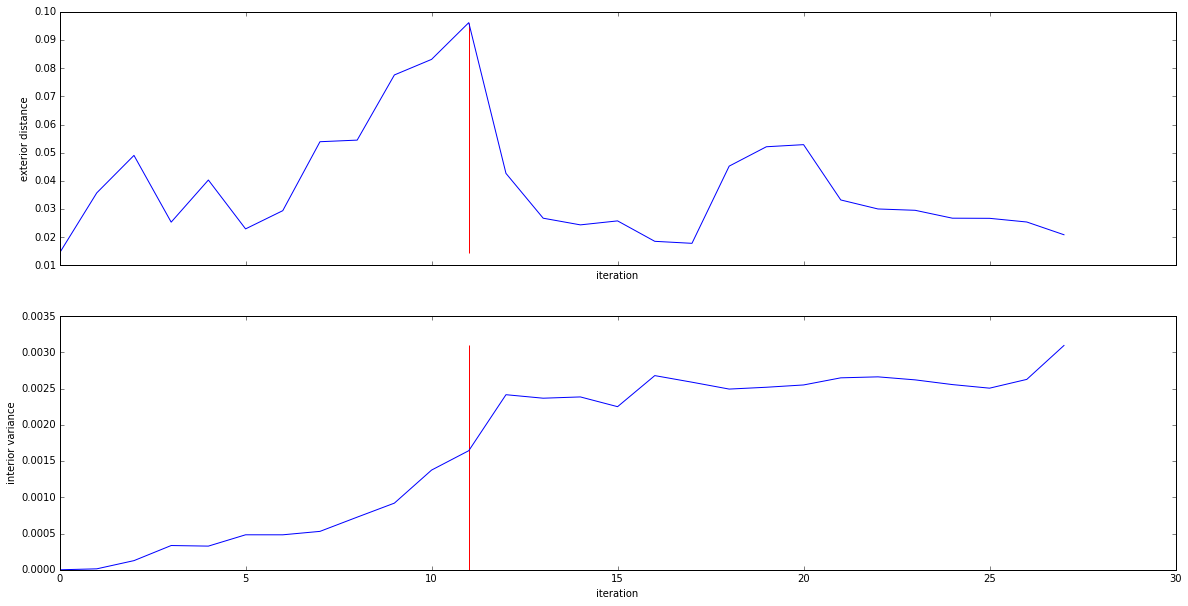

In [18]:
fig, axes = plt.subplots(2,1,squeeze=True, sharex=True, figsize=(20,10))

scores_to_plot = score_tuples[:,1]
axes[0].plot(scores_to_plot);
for p in peaks_sorted:
    axes[0].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[0].set_xlabel('iteration');
axes[0].set_ylabel('exterior distance');

scores_to_plot = score_tuples[:,3]
axes[1].plot(scores_to_plot);
for p in peaks_sorted:
    axes[1].vlines(p, ymin=scores_to_plot.min(), ymax=scores_to_plot.max(), colors='r');
axes[1].set_xlabel('iteration');
axes[1].set_ylabel('interior variance');

In [ ]:
t = time.time()
clusters, scores = grow_cluster4(891, all_history=False, verbose=False)
print time.time() - t

In [17]:
margin = 300

xmin = np.inf
ymin = np.inf
xmax = 0
ymax = 0

for cl, sc in zip(*expansion_clusters_tuples[1419]):

    centroids = sp_centroids[cl]
    xmin = min(xmin, centroids[:,0].min(axis=0))
    xmax = max(xmax, centroids[:,0].max(axis=0))
    ymin = min(ymin, centroids[:,1].min(axis=0))
    ymax = max(ymax, centroids[:,1].max(axis=0))

xmin = int(max(0, xmin - margin))
ymin = int(max(0, ymin - margin))
xmax = int(min(dm.image_width, xmax + margin))
ymax = int(min(dm.image_height, ymax + margin))

print ymin, xmin, ymax, xmax


for cl, sc in zip(*expansion_clusters_tuples[1419]):
        
    viz = dm.visualize_cluster(cl, highlight_seed=True, 
                               ymin=ymin, xmin=xmin, ymax=ymax, xmax=xmax)
    plt.imshow(viz)
    plt.axis('off')
    plt.title('cluster score %.3f'%(sc))
    plt.show()

NameError: name 'expansion_clusters_tuples' is not defined

In [ ]:
sys.stderr.write('growing regions ...\n')
t = time.time()
expansion_clusters_tuples = Parallel(n_jobs=16)(delayed(grow_cluster4)(s) for s in range(n_superpixels))
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)

In [ ]:
all_see_cluster_tuples = [(s,c) for s in range(n_superpixels)  for c in expansion_clusters[s] ]
all_cluster_scores = [c for s in range(n_superpixels)  for c in expansion_cluster_scores[s]]

all_seeds, all_clusters = zip(*all_see_cluster_tuples)

In [ ]:
edge_coords = dm.load_pipeline_result('edgeCoords')
dedge_neighbors = dm.load_pipeline_result('dedgeNeighbors')
dedge_neighbor_graph = from_dict_of_lists(dedge_neighbors)

# edges_long = [e for e in edge_coords.iterkeys() if len(edge_coords[e]) > 10]

# neighbors_long = []
# for s, nbrs in enumerate(neighbors):
#     neighbors_long.append( set([n for n in nbrs if len(edge_coords[frozenset([n,s])]) > 10]))
    
# neighbors_long_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors_long]))
# neighbors_long_graph = from_dict_of_lists(neighbors_long_dict)

# neighbor_graph = from_dict_of_lists(dict(enumerate(map(list, neighbors))))


In [ ]:
from networkx.algorithms import dfs_successors, dfs_postorder_nodes

def order_nodes(sps, neighbor_graph):

    subg = neighbor_graph.subgraph(sps)
    d_suc = dfs_successors(subg)
    
    x = [(a,b) for a,b in d_suc.iteritems() if len(b) == 2]
    
    if len(x) == 0:
        trav = list(dfs_postorder_nodes(subg))
    else:
        root, two_leaves = x[0]

        left_branch = []
        right_branch = []

        c = two_leaves[0]
        left_branch.append(c)
        while c in d_suc:
            c = d_suc[c][0]
            left_branch.append(c)

        c = two_leaves[1]
        right_branch.append(c)
        while c in d_suc:
            c = d_suc[c][0]
            right_branch.append(c)

        trav = left_branch[::-1] + right_branch
        
    return trav

In [ ]:
def find_boundary_dedges_ordered(cluster):

    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster])
    surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])
#     surrounds_ordered = order_nodes(surrounds, linking_neighbor_graph)
    
#     frontiers = (set.union(*[neighbors[c] for c in surrounds]) | set()) & set(cluster)
#     print surrounds
    
    non_border_dedges = [(s, int_sp) for s in surrounds for int_sp in set.intersection(set(cluster), neighbors[s]) 
                         if int_sp != -1 and s != -1]
    border_dedges = [(-1,f) for f in cluster if -1 in neighbors[f]] if -1 in surrounds else []
            
    dedges_cluster = non_border_dedges + border_dedges
    dedges_cluster_long = [dedge for dedge in dedges_cluster if len(edge_coords[frozenset(dedge)]) > 10]
    dedges_cluster_long_sorted = order_nodes(dedges_cluster_long, dedge_neighbor_graph)    
    
    return dedges_cluster_long_sorted

In [ ]:
dedges_cluster_long_sorted = find_boundary_dedges_ordered(all_clusters[all_seeds.index(3783)])

viz = dm.visualize_edge_set(dedges_cluster_long_sorted, bg='segmentationWithText', show_edge_index=True)
display(viz)

In [ ]:
viz = dm.visualize_cluster(all_clusters[4000], seq_text=False, highlight_seed=False) 
display(viz)

In [ ]:
for i, c in enumerate(all_clusters[11000:]):
#     if i%1000 == 0: sys.stderr.write('%d\n'%i)
    try:
        r = find_boundary_dedges_ordered(c)
    except:
        print i

In [ ]:
sys.stderr.write('find boundary edges ...\n')
t = time.time()
all_cluster_dedges = Parallel(n_jobs=16)(delayed(find_boundary_dedges_ordered)(c) for c in all_clusters)
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
dm.save_pipeline_result(zip(all_seeds, all_clusters, all_cluster_scores, all_cluster_dedges), 'allSeedClusterScoreDedgeTuples')